In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

**NB**: make sure you have social-network application running on `localhost:8080`

In [54]:
! ./run-load-test.sh

mysql: [Warning] Using a password on the command line interface can be insecure.
Running 2m test @ http://localhost:8080/social-network/api/user/?limit=5000
  1 threads and 1 connections
  Thread Stats   Avg      Stdev     Max   +/- Stdev
    Latency   444.31ms   19.92ms 537.73ms   74.81%
    Req/Sec     1.91      0.29     2.00     90.74%
  Latency Distribution
     50%  440.84ms
     75%  456.77ms
     90%  471.07ms
     99%  505.46ms
  270 requests in 2.00m, 1.67MB read
Requests/sec:      2.25
Transfer/sec:     14.26KB
Running 2m test @ http://localhost:8080/social-network/api/user/?limit=5000
  8 threads and 10 connections
  Thread Stats   Avg      Stdev     Max   +/- Stdev
    Latency   852.99ms   93.97ms   1.17s    56.38%
    Req/Sec     0.88      0.33     1.00     87.51%
  Latency Distribution
     50%  847.86ms
     75%  933.15ms
     90%  975.73ms
     99%    1.08s 
  1121 requests in 2.00m, 8.68MB read
Requests/sec:      9.34
Transfer/sec:     74.05KB
Running 2m test @ http://

Note, that where are considerably more timeouted requests without index for 1000 connections

In [58]:
no_index_df = pd.read_csv("no_index.csv")
no_index_df["index"] = False

with_index_df = pd.read_csv("with_index.csv")
with_index_df["index"] = True

df = no_index_df.append(with_index_df)
df.head(10)

,connections,latencyp90[ms],throughput[rps],index
0,1,471.070,2.249259,False
1,10,975.728,9.337131,False
2,100,17500.564,8.278694,False
3,1000,27204.131,10.424700,False
0,1,426.450,16.936633,True
1,10,817.696,69.938167,True
2,100,2771.297,69.241338,True
3,1000,20486.732,64.387152,True


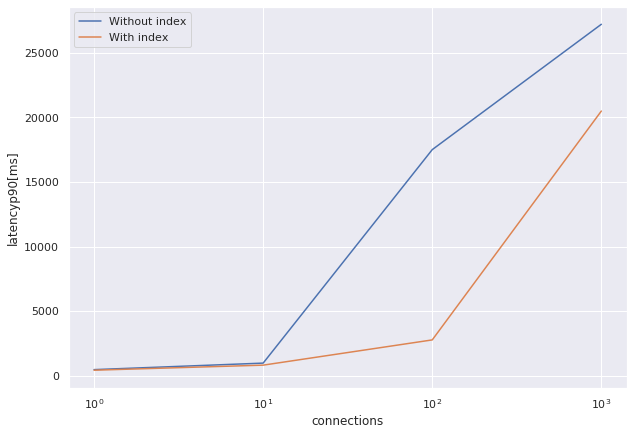

In [56]:
sns.set(rc = {"figure.figsize": (10, 7)})

ax = sns.lineplot(x = "connections", y = "latencyp90[ms]", hue = "index", data = df)

ax.legend(["Without index", "With index"])
ax.set_xscale('log')

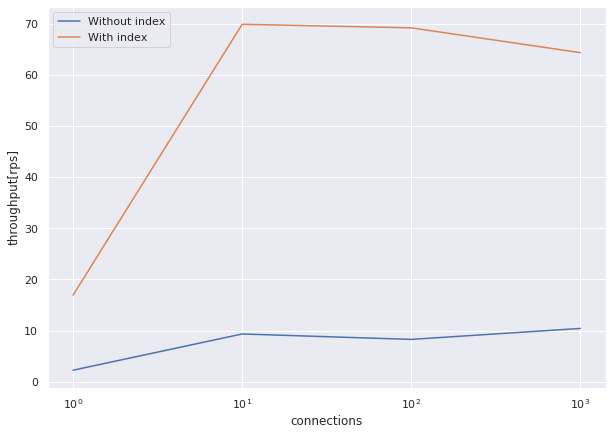

In [59]:
ax = sns.lineplot(x = "connections", y = "throughput[rps]", hue = "index", data = df)

ax.legend(["Without index", "With index"])
ax.set_xscale('log')

In [60]:
print("Used index:")
! cat create-LN_FN_ID_DESC_INDX.sh

Used index:
../social-network/scripts/docker-compose/docker-mysql-exec.sh \
  "CREATE index LN_FN_ID_DESC_INDX on USER_PERSONAL_DETAILS(LAST_NAME, FIRST_NAME, ID DESC);"


In [61]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

print("""
+----+-------------+-----------------------+------------+--------+--------------------------------------+--------------------+---------+------------------------------------------------+-------+----------+---------------------------------------+
| id | select_type | table                 | partitions | type   | possible_keys                        | key                | key_len | ref                                            | rows  | filtered | Extra                                 |
+----+-------------+-----------------------+------------+--------+--------------------------------------+--------------------+---------+------------------------------------------------+-------+----------+---------------------------------------+
|  1 | SIMPLE      | USER_PERSONAL_DETAILS | NULL       | range  | FK_GENDER,FK_CITY,LN_FN_ID_DESC_INDX | LN_FN_ID_DESC_INDX | 2044    | NULL                                           | 25232 |    11.11 | Using index condition; Using filesort |
|  1 | SIMPLE      | GENDER                | NULL       | eq_ref | PRIMARY                              | PRIMARY            | 8       | social_network.USER_PERSONAL_DETAILS.GENDER_ID |     1 |   100.00 | NULL                                  |
|  1 | SIMPLE      | CITY                  | NULL       | eq_ref | PRIMARY                              | PRIMARY            | 8       | social_network.USER_PERSONAL_DETAILS.CITY_ID   |     1 |   100.00 | NULL                                  |
+----+-------------+-----------------------+------------+--------+--------------------------------------+--------------------+---------+------------------------------------------------+-------+----------+---------------------------------------+

""")


+----+-------------+-----------------------+------------+--------+--------------------------------------+--------------------+---------+------------------------------------------------+-------+----------+---------------------------------------+
| id | select_type | table                 | partitions | type   | possible_keys                        | key                | key_len | ref                                            | rows  | filtered | Extra                                 |
+----+-------------+-----------------------+------------+--------+--------------------------------------+--------------------+---------+------------------------------------------------+-------+----------+---------------------------------------+
|  1 | SIMPLE      | USER_PERSONAL_DETAILS | NULL       | range  | FK_GENDER,FK_CITY,LN_FN_ID_DESC_INDX | LN_FN_ID_DESC_INDX | 2044    | NULL                                           | 25232 |    11.11 | Using index condition; Using filesort |
|  1 | SIMPLE      

### Index explanation

* In order to search with predicate `LAST_NAME like 'last_name_prefix%' and FIRST_NAME like 'first_name_prefix'`
we can use multicolumn B-tree index on `LAST_NAME` and `FIRST_NAME`.
* `LAST_NAME` is more selective then `FIRST_NAME`, hence `LAST_NAME` comes first.
* Finally, we add index `ID DESC` - this can slightly boost sorting the result.